# Baseball hall of fame pitchers 
------

## Grant Phillips

Question
----




Given a dataset of historical hall of fame ballot results and various pitching statistics, can I predict whether a pitcher on the hall of fame ballot will be inducted?

# Imports

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from   sklearn.ensemble           import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model    import LogisticRegression, RidgeClassifier, Lasso
from sklearn.metrics         import f1_score, balanced_accuracy_score, confusion_matrix, average_precision_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score
from   sklearn.preprocessing      import *
from   sklearn.base               import BaseEstimator
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE 
from imblearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve


#### Path where all data exists

In [2]:
PATH = Path("../data/baseballdatabank-master/core/")

#### Load in two csv's with data of interest

In [3]:
hof_df = pd.read_csv(PATH/"HallOfFame.csv")
pitching_df = pd.read_csv(PATH/"Pitching.csv")

# Prepare data for Scikit learn pipeline and deal with transformations that require target transformation

#### One hot encode target (induction result) so the feature is not lost when we aggregate

In [4]:
hof_df['inducted'] = OneHotEncoder().fit_transform(np.array(hof_df['inducted']).reshape(-1,1)).toarray()[:,1]

#### Merge dataframes to one dataset

In [5]:
data = pitching_df.merge(hof_df, how='inner', on='playerID').drop_duplicates(subset=list(pitching_df.columns)[2:], keep='last')

#### Only include players (exclude managers, executives, etc)

In [6]:
data_players = data[data['category'] == 'Player']

#### Get career statistics for each player

In [7]:
data_agg = data_players.groupby('playerID').sum()

#### Filter out players with little pitching experience

In [8]:
data_pitchers = data_agg[data_agg['BFP'] > 1000]

#### Fix target column again

In [9]:
data_pitchers['inducted'] = (np.array(data_pitchers['inducted']) > 0).astype(int)

<ipython-input-9-cb8b8e68258e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pitchers['inducted'] = (np.array(data_pitchers['inducted']) > 0).astype(int)


In [10]:
data_pitchers.head().T

playerID,abbotji01,adamsba01,aguilri01,akerja01,alexado01
yearID_x,21932.000,36411.00,37863.000,27574.00,45552.000
stint,12.000,19.00,22.000,17.00,27.000
W,87.000,194.00,86.000,47.00,194.000
L,108.000,140.00,81.000,45.00,174.000
G,263.000,482.00,732.000,495.00,561.000
GS,254.000,355.00,89.000,0.00,464.000
CG,31.000,206.00,10.000,0.00,98.000
SHO,6.000,44.00,0.000,0.00,18.000
SV,0.000,15.00,318.000,123.00,3.000
IPouts,5022.000,8986.00,3874.000,2238.00,10103.000


# Seperate Features and Targets

In [11]:
y = data_pitchers['inducted']
X = data_pitchers.drop(['inducted'],axis=1)

# Let's set aside a test set to evalute our models at the end

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=2021) 

# Feature Engineering

### Define custom transformer to drop features

### Drop features related to ballot voting results in order to prevent data leakage. Includes 'votes', 'needed', and 'ballots'.
### Drop features that are not helpful due to aggregation, such as ERA and BAOpp (Averages)

In [13]:
class CustomTransformer():
    def __init__(self, func):
        self.func = func

    def transform(self, input_df, **transform_params):
        return self.func(input_df)

    def fit(self, X, y=None, **fit_params):
        return self

def drop_features(df):
    df = df.drop(['votes', 'needed', 'ballots', 'yearID_y', 'ERA', 'BAOpp', 'yearID_x'], axis=1)

    return df


## Final Features

- Wins
- Loss
- Games
- Games started
- Complete Games
- Shutouts
- Saves
- Outs Pitched
- Hits
- Earned Runs
- Home runs
- Walks
- Strikeouts
- Intentional Walks
- Wild Pitches
- Hit Batters
- Balks
- Batters faced by pitcher
- Games finished
- Runs allowed
- Sacrifices by opposing batters
- Sacrifice flies by opposing batters
- Grounded into double plays by opposing batter
- Seasons

# Missing Data

### IBB (Intentional Walks) , GIDP (Grounded Into Double Play), SF (Sacrifice Flys), HBP (Hit By Pitch), and SH (Sacrifice Bunts) were not recorded in the early days of baseball

### Replace missing values with median value using ColumnTransformer and SimpleImputer

In [14]:
column_tranf = ColumnTransformer([
                                ('imp_cols', SimpleImputer(missing_values=0, strategy='median'), [23, 22, 21, 16, 14])
                                ], remainder='passthrough')

# Imbalanced Data

In [15]:
print(f'Percent hall of famers in data = {Counter(y)[1]/len(X) * 100:.2f}%')
print(f'Percent not hall of famers in data = {Counter(y)[0]/len(X) * 100:.2f}%')

Percent hall of famers in data = 17.56%
Percent not hall of famers in data = 82.44%


#### Data is imbalanced due to the Baseball hall of fame being an exclusive club
#### Solution: Use smote to synthetically generate samples from minority class

# Choosing Model Candidates

### Evaluation Metrics:
1. Balanced accuracy:
    - It can be a naive metric, but is easy to understand
    - Should not be given too much weight, especially with imbalanced data
2. F1-Weighted:
    - Combines Recall (Fraction of True Postives to Actual Positives) and Precision (Fraction of True Positves to Predicted Positives)
    - Good metric for imbalanced data
3. Average Precision:
    - Summarizes the precision-recall curve
    - For reference: https://sanchom.wordpress.com/tag/average-precision/

## Setup cv search across algorithms and hyperparameters to get best values

In [16]:
# Helper class (provided by Brian in one of our class assignments)
class DummyEstimator(BaseEstimator):
    "Pass through class, methods are present but do nothing."
    def fit(self): pass
    def score(self): pass

In [17]:
# Setup pipeline to cv search across algorthims
pipe = Pipeline([('transformer', CustomTransformer(drop_features)),
                ('col_transformer', column_tranf),
                ('sm', SMOTE()),
                ('scaler', MinMaxScaler()),
                ('clf', DummyEstimator())
                ])

# Let's first select a linear model

## Use Randomized search to search across several different models and hyperparameters

1. LogisticRegression
    - penalty: pick what type of regularization we want to use
    - class weight: probably good to include since we have imbalanaced imbalanced data
    
    
2. RidgeClassifier
    - alpha: represents strength of regularization
    - class_weight: probably good to include since we have imbalanaced imbalanced data
 
 
3. Lasso
    - alpha:  represents strenght of L1 regularization
    - Doesn't seem to have a class_weight hyperparameter, but does include feature selection

In [18]:
search_space = [
                
                {'clf': [LogisticRegression()],
                 'clf__penalty': ['l1', 'l2', 'elasticnet']},
               
                {'clf': [RidgeClassifier()],
                 'clf__alpha': [0.001, 0.01, 0.1, 1]},

                {'clf': [Lasso()],
                 'clf__alpha': [0.1, 0.5, 0.75, 1]},
    
               ]

clf_algos_rand = RandomizedSearchCV(estimator=pipe, 
                                    param_distributions=search_space, 
                                    n_iter=21,
                                    cv=5, 
                                    n_jobs=-1,
                                    scoring='balanced_accuracy',
                                    verbose=1)

# Grid search
linear_model = clf_algos_rand.fit(X_train, y_train);

# View best model
linear_estimator = linear_model.best_estimator_.get_params()['clf']
linear_estimator

Fitting 5 folds for each of 11 candidates, totalling 55 fits


RidgeClassifier(alpha=1)

In [19]:
linear_pipe = Pipeline([('transformer', CustomTransformer(drop_features)),
                ('col_transformer', column_tranf),
                ('sm', SMOTE()),
                ('scaler', MinMaxScaler()),
                ('linear', linear_estimator)
                ])
linear_pipe.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 <__main__.CustomTransformer object at 0x7f8430b39430>),
                ('col_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('imp_cols',
                                                  SimpleImputer(missing_values=0,
                                                                strategy='median'),
                                                  [23, 22, 21, 16, 14])])),
                ('sm', SMOTE()), ('scaler', MinMaxScaler()),
                ('linear', RidgeClassifier(alpha=1))])

# Let's try some ensemble models now

##  Use Randomized search to search across hyperparamers

1. RandomForestClassifier
2. ExtraTreesClassifier
    - Criterion: 
        - Gini: measures how pure the class split is
        - Entropy: measures information gain
    - Max Depth:
        - Puts a limit on the depth of the tree
        - Stops trees from overfitting
    - Min Samples Leaf:
        - Limits leaves with few samples
    - Class Weight:
        - Could be useful to look at since we have unbalanced labels
        

In [20]:
# Setup pipeline to cv search across algorthims
pipe = Pipeline([('transformer', CustomTransformer(drop_features)),
                ('col_transformer', column_tranf),
                ('sm', SMOTE()),
                ('scaler', MinMaxScaler()),
                ('clf', DummyEstimator())
                ])

# Create search space of candidate algorthims and their hyperparameters
# Search for optimal criterion, max_depth, min_samples
search_space = [
                
                {'clf': [RandomForestClassifier()],
                 'clf__criterion': ['gini', 'entropy'],
                 'clf__max_depth': [None, 5, 10, 15, 20, 25],
                 'clf__min_samples_leaf': [1, 3, 5, 10, 25, 100],
                 'clf__max_features': ['auto', 'sqrt', 'log2']},
    
                {'clf': [ExtraTreesClassifier()],
                 'clf__criterion': ['gini', 'entropy'],
                 'clf__max_depth': [None, 5, 10, 15, 20, 25],
                 'clf__min_samples_leaf': [1, 3, 5, 10, 25, 100],
                 'clf__max_features': ['auto', 'sqrt', 'log2']}

                
               ]
clf_algos_rand = RandomizedSearchCV(estimator=pipe, 
                                    param_distributions=search_space, 
                                    n_iter=500,
                                    cv=5, 
                                    n_jobs=-1,
                                    scoring='balanced_accuracy',
                                    verbose=1)

# Grid search
ensemble_model = clf_algos_rand.fit(X_train, y_train);

ensemble_estimator = ensemble_model.best_estimator_.get_params()['clf']
ensemble_estimator

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


RandomForestClassifier(criterion='entropy', max_depth=20, max_features='log2',
                       min_samples_leaf=25)

In [21]:
ensemble_pipe = Pipeline([('transformer', CustomTransformer(drop_features)),
                ('col_transformer', column_tranf),
                ('sm', SMOTE()),
                ('scaler', MinMaxScaler()),
                ('linear', ensemble_estimator)
                ])
ensemble_pipe.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 <__main__.CustomTransformer object at 0x7f843139e5b0>),
                ('col_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('imp_cols',
                                                  SimpleImputer(missing_values=0,
                                                                strategy='median'),
                                                  [23, 22, 21, 16, 14])])),
                ('sm', SMOTE()), ('scaler', MinMaxScaler()),
                ('linear',
                 RandomForestClassifier(criterion='entropy', max_depth=20,
                                        max_features='log2',
                                        min_samples_leaf=25))])

# Use candidate models and compare cross validation scores

In [22]:
linear_acc_cv_scores = cross_val_score(linear_pipe, X_train, y_train, scoring='balanced_accuracy', cv=5, verbose=False)
ensemble_acc_cv_scores = cross_val_score(ensemble_pipe, X_train, y_train, scoring='balanced_accuracy', cv=5, verbose=False)
print(f"Balanced accuracy score for best linear model is {linear_acc_cv_scores.mean():.2f}")
print(f"Balanced accuracy score for best ensemble model is {ensemble_acc_cv_scores.mean():.2f}")

Balanced accuracy score for best linear model is 0.82
Balanced accuracy score for best ensemble model is 0.82


In [23]:
linear_f1_cv_scores = cross_val_score(linear_pipe, X_train, y_train, scoring='f1_weighted', cv=5, verbose=False)
ensemble_f1_cv_scores = cross_val_score(ensemble_pipe, X_train, y_train, scoring='f1_weighted', cv=5, verbose=False)
print(f"Average weighted f1 score for best linear model is {linear_f1_cv_scores.mean():.2f}")
print(f"Average weighted f1 score for best ensemble model is {ensemble_f1_cv_scores.mean():.2f}")

Average weighted f1 score for best linear model is 0.89
Average weighted f1 score for best ensemble model is 0.86


In [24]:
linear_ap_cv_scores = cross_val_score(linear_pipe, X_train, y_train, scoring='average_precision', cv=5, verbose=False)
ensemble_ap_cv_scores = cross_val_score(ensemble_pipe, X_train, y_train, scoring='average_precision', cv=5, verbose=False)
print(f"Average precision score for best linear model is {linear_ap_cv_scores.mean():.2f}")
print(f"Average precision score for best ensemble model is {ensemble_ap_cv_scores.mean():.2f}")

Average precision score for best linear model is 0.77
Average precision score for best ensemble model is 0.71


# Model Selection

#### The best linear model usually scores a little better than the ensemble model in all of the metrics

#### Therefore the linear model will be selected as our final model

In [25]:
# Final model parameters
linear_pipe.named_steps['linear']

RidgeClassifier(alpha=1)

In [26]:
# Full final pipeline
linear_pipe.named_steps

{'transformer': <__main__.CustomTransformer at 0x7f8430b39430>,
 'col_transformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('imp_cols',
                                  SimpleImputer(missing_values=0,
                                                strategy='median'),
                                  [23, 22, 21, 16, 14])]),
 'sm': SMOTE(),
 'scaler': MinMaxScaler(),
 'linear': RidgeClassifier(alpha=1)}

# Final Model Test Perfomance

In [27]:
final_model_preds = linear_pipe.predict(X_test)

### Correlation Matrix

In [28]:
pd.DataFrame(confusion_matrix(y_true=y_test, y_pred=final_model_preds, labels=[0, 1]))

,0,1
0,57,9
1,1,15


### Metric Performance

In [29]:
balanced_acc_test = balanced_accuracy_score(y_test, final_model_preds)
f1_test = f1_score(y_test, final_model_preds, average='weighted')
average_precision_test = average_precision_score(y_test, final_model_preds)

In [30]:
print(f'Balanced accuracy on the test set = {balanced_acc_test:.2f}')
print(f'Weighted f1 score on the test set = {f1_test:.2f}')
print(f'Average precision score on the test set = {average_precision_test:.2f}')

Balanced accuracy on the test set = 0.90
Weighted f1 score on the test set = 0.89
Average precision score on the test set = 0.60


### Precision Recall Curve

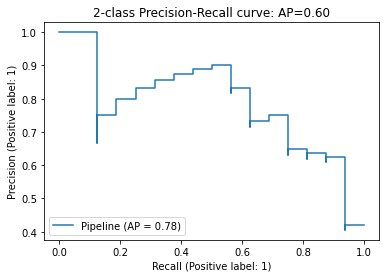

In [31]:
disp = plot_precision_recall_curve(linear_pipe, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision_test));

# Let's take a look at feature importance now